# Homework 7 (50 points)

In this Homework, we will try to classify observations of space to be either stars, galaxies or quasars based on the RD14 from the Sloan Digital Sky Survey  (SDSS). The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested. 

http://www.sdss.org/
![alt text](http://www.fingerprintdigitalmedia.com/wp-content/uploads/2014/08/sdss1.jpg)

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.


In this homework we will train several classifier to predict the class of a celestial object based on the observations (features). We will practice data prep, dimensionality reduction, model design and training, model comparison, and feature importance selection.

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline


## 1) Data Preparation (20 points)

We follow the following steps:
* read (1 point)
* clean (3 points)
* correlate (4 points)
* explore, spread of values (3 points)
* dimensionality reduction (9 points)

### 1.1 Data read
Read the pandas fata frame from the csv file "Skyserver_SQL2_27_2018.csv" and skip the first row.

**Task: read (1 point)**

Save a copy of the data frame just in case.

In [2]:
# answer
sdss_df = pd.read_csv('Skyserver_SQL2_27_2018.csv',skiprows=0)
sdss_df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,0.000000e+00,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


**Description of the data fields**

* objid = Object Identifier, self explanatory.
* ra = J2000 Right Ascension (r-band). Angular that is measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question.   https://en.wikipedia.org/wiki/Right_ascension
* dec = J2000 Declination (r-band). Angle that is measured north or south of the celestial equator, along the hour circle passing through the point in question. https://en.wikipedia.org/wiki/Declination



The Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further Information: http://astroweb.case.edu/ssm/ASTR620/mags.html 
* u = better of DeV/Exp magnitude fit
* g = better of DeV/Exp magnitude fit
* r = better of DeV/Exp magnitude fit
* i = better of DeV/Exp magnitude fit
* z = better of DeV/Exp magnitude fit




Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. 
* run = Run Number, which identifies the specific scan. 
* rereun = Rerun Number, which specifies how the image was processed.
* camcol = Camera column, a number from 1 to 6, identifying the scanline within the run.
* field = Field number, which typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.
* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object): The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.

* redshift = Final Redshift: In physics, **redshift** happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum. 

* plate = plate number: Each spectroscopic exposure employs a large, thin, circular metal **plate** that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

* mjd = MJD of observation, **Modified Julian Date**, used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.
* fiberid = fiber ID. The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding **fiberID**. 

**Further information on SDSS images and their attributes:** 

http://www.sdss3.org/dr9/imaging/imaging_basics.php

http://www.sdss3.org/dr8/glossary.php

### 1.2 Data Cleaning 

Basic stats about our dataset. 

**Task: Provide basic infor for the pandas dataframe head (0.5 point)**

In [3]:
# head
print(sdss_df.head())
sdss_df.describe()

          objid          ra       dec         u         g         r         i  \
0  1.237650e+18  183.531326  0.089693  19.47406  17.04240  15.94699  15.50342   
1  1.237650e+18  183.598370  0.135285  18.66280  17.21449  16.67637  16.48922   
2  1.237650e+18  183.680207  0.126185  19.38298  18.19169  17.47428  17.08732   
3  1.237650e+18  183.870529  0.049911  17.76536  16.60272  16.16116  15.98233   
4  1.237650e+18  183.883288  0.102557  17.55025  16.26342  16.43869  16.55492   

          z  run  rerun  camcol  field     specobjid   class  redshift  plate  \
0  15.22531  752    301       4    267  3.722360e+18    STAR -0.000009   3306   
1  16.39150  752    301       4    267  3.638140e+17    STAR -0.000055    323   
2  16.80125  752    301       4    268  3.232740e+17  GALAXY  0.123111    287   
3  15.90438  752    301       4    269  3.722370e+18    STAR -0.000111   3306   
4  16.61326  752    301       4    269  3.722370e+18    STAR  0.000590   3306   

     mjd  fiberid  
0  549

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,0.000000e+00,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


**Task: Find the data types of the database (floats, string, etc etc) using the ``info()`` function (0.5 point).**

In [4]:
# information
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


Are there any obvious feature (or element of the dataframe) that should not impact our prediction?
 
**objid** and **specobjid** are just identifiers for accessing the rows back when they were stored in the original databank. Therefore we will not need them for classification as they are not related to the outcome.
The features **run**, **rerun**, **camcol** and **field** are values which describe parts of the camera at the moment when making the observation, e.g. 'run' represents the corresponding scan which captured the oject.

Source: http://www.sdss3.org/dr9/imaging/imaging_basics.php

**Task: Drop these columns in the pandas dataframe. (1 point)**

In [5]:
# answer
sdss_df.drop(['objid','specobjid','run','rerun','camcol','field','plate','fiberid'],axis = 1, inplace=True)


Find our how many examples there are, how many attributes or feature, and the type of class.

In [6]:
# description
print('There are', len(sdss_df['class']), 'examples in ',len(sdss_df['class'].unique()),'classes of', sdss_df['class'].unique() )


There are 10000 examples in  3 classes of ['STAR' 'GALAXY' 'QSO']


**Task: How many objects are in each class? (1 point)**

In [7]:
# Count the elements in each class
sdss_df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

The classes are "GALAXY", "STAR", and "QSO" (quasars). They are defined as strings, but we will convert them to integer in order to apply a loss function on the class labels during training. For this, we use the ``sklearn.preprocessing.LabelEncoder()`` function. We will do so and modify the classes in the dataframe. We should keep a copy of the original data frame to be safe.

In [8]:
sdss_df_save = sdss_df # make a copy of the original data before cleaning it. That works well when the data is small.

# encode class labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df['class'])
sdss_df['class'] = y_encoded
#  GALAXY = 0
# STAR = 1
# QSO = 2

### 1.3 Data correlations
Now let's find the most basic correlations among features. This can be done using the ``corr()`` function to apply on the pandas dataframe. Evaluate this function and comment on what feature is correlated among others. It is convenient to use the matplotlib function ``matshow()`` for clarity. ``seaborn`` is a python module that makes really pretty statistical plots https://seaborn.pydata.org/index.html#. Install it with ``pip`` and import it.

In [9]:
import seaborn as sns

**Task: Plot the correlation matrix that can be called in the pandas dataframe. (2 points)**

Hints:

Use functions of ``heatmap``, add the labels in the axes. The colormap ``coolwarm`` is nice for divergent scales like correlations that vary between -1 and 1. The argument ``center=0`` ensures that the colormap is divergent from zero. Make sure to ignore the label column "class". Remember that dropping a column can be done in place ``sdss_df.drop('class', axis=1)``.

Text(0.5, 1.0, 'Correlation matrix for all features')

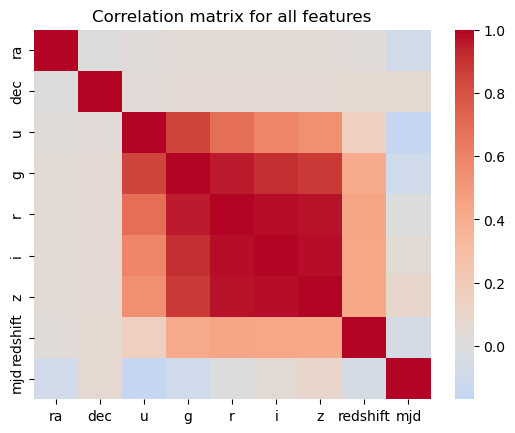

In [10]:
# answer
plt.figure()
sns.heatmap(sdss_df.drop('class',axis=1).corr(),cmap='coolwarm',center=0)
plt.title('Correlation matrix for all features')


**Task: Reproduce the same plot for each of the three classes. (1 point)**
You can select the values from the pandas dataframe by selecting over the column 'class'. 

Text(0.5, 1.0, 'Quasars Class correlations')

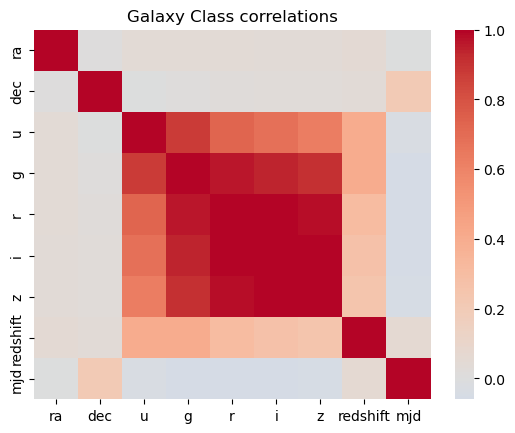

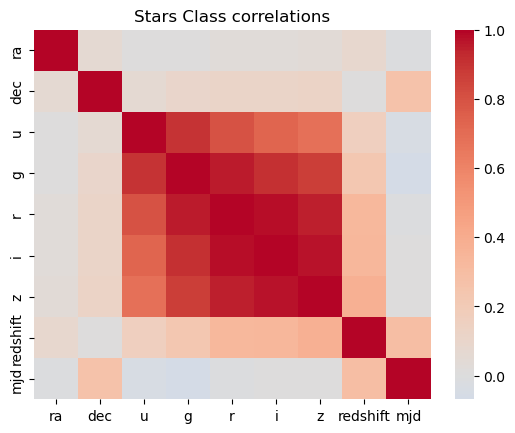

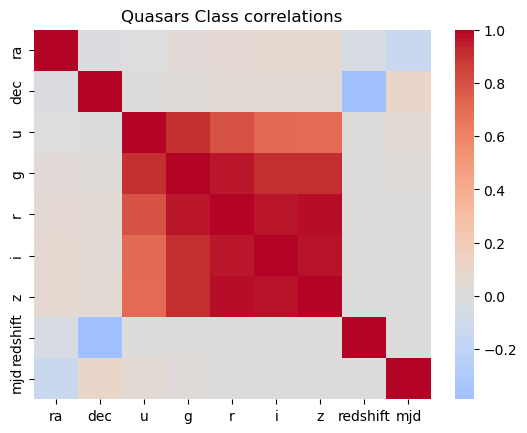

In [11]:
# make the same plot for Galaxies
# "GALAXY" is label 0
plt.figure()
sns.heatmap(sdss_df[sdss_df['class']==0].drop('class', axis=1).corr(),center=0,cmap='coolwarm')
plt.title('Galaxy Class correlations')
# Make the same plot for Stars (label 1)
plt.figure()
sns.heatmap(sdss_df[sdss_df['class']==1].drop('class', axis=1).corr(),center=0,cmap='coolwarm')
plt.title('Stars Class correlations')
# make the same plots for quasars (label 2)
plt.figure()
sns.heatmap(sdss_df[sdss_df['class']==2].drop('class', axis=1).corr(),center=0,cmap='coolwarm')
plt.title('Quasars Class correlations')

**Task: Can you comment on groups of observations that can be grouped together or that appear independent from each other given these correlations, and if there is any difference between the three celestial objects? (**1 point**)**

The correlations between variables in the Galaxy and Star classes are very similar. Variables u, g, r, i, and z are all highly correlated with one another as well as variables plate and mjd.

Quasars however, have some variables that are actually negatively correlated with others (i.e. redshift).

### 1.5 Data exploration
Given the structure of the correlations, we will explore the values of the data.

#### 1.5.a. Distributions of redshift
"redshifting" happens when the source of light is becoming more distant to the receiver: the object is moving away from Earth. 

**Task: plot histograms for the 'redshift' feature column for each class (1 point).**

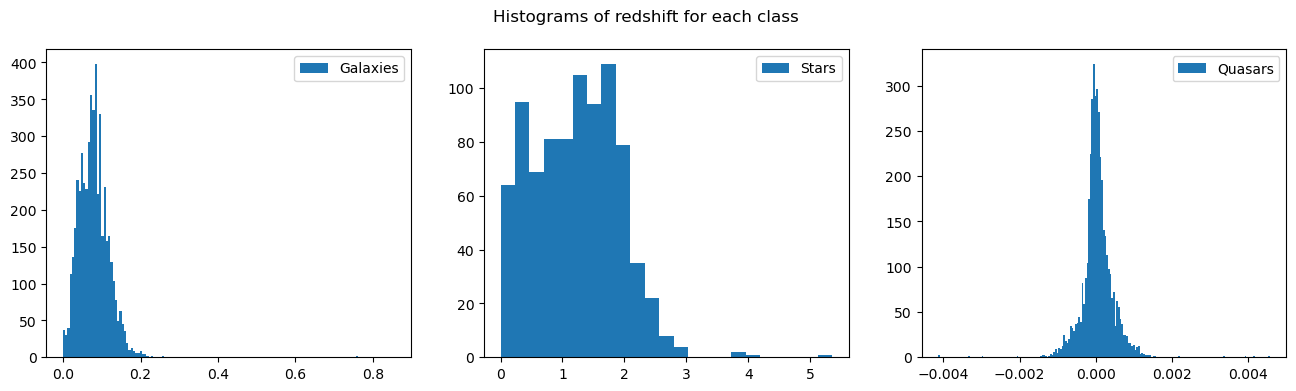

In [12]:
# answer using inter quartile range to determine bin width
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
for i in range(3):
    q25, q75 = np.percentile(sdss_df[sdss_df['class']==i]['redshift'], [25, 75])
    bin_width = 2 * (q75 - q25) * len(sdss_df[sdss_df['class']==i]['redshift']) ** (-1/3)
    bins = round((sdss_df[sdss_df['class']==i]['redshift'].max() - sdss_df[sdss_df['class']==i]['redshift'].min()) / bin_width)
    if i == 0:
        axes[i].hist(sdss_df[sdss_df['class']==i]['redshift'],bins=bins,label='Galaxies');
        axes[i].legend()
    if i == 1:
        axes[i].hist(sdss_df[sdss_df['class']==i]['redshift'],bins=bins,label='Stars');
        axes[i].legend()
    if i == 2:
        axes[i].hist(sdss_df[sdss_df['class']==i]['redshift'],bins=bins,label='Quasars');
        axes[i].legend()
plt.suptitle('Histograms of redshift for each class');

**Task : Describe briefly the difference between the three histograms. (0.5 point)**

<!-- # answer -->
* **Star:** The histogram looks like a truncated zero-centered normal distribution. It looks like stars are both coming toward and away from the Earth.

* **Galaxy:** The redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075. It looks like galaxies are moving away from the Earth but at slow speeds.

* **QSO:** The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed around 0, then the occurences decrease drastically. For 4 oder ~5.5 there are some outliers. This probably means that quasars are moving away from the earth with a diverse range of speeds.


#### 1.5.b. Right ascension (ra) and declination (dec) 

We will now plot the right ascension versus the declination depending on the class. You can use the ``lmplot`` function in ``seaborn`` (https://seaborn.pydata.org/generated/seaborn.lmplot.html) to represent the sky view of these objects.

Text(0.5, 1.0, 'Equatorial coordinates')

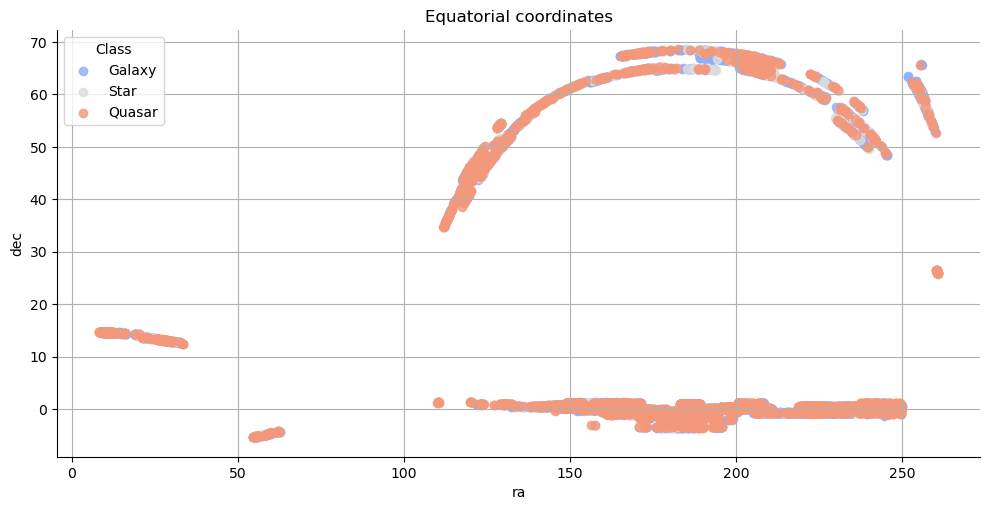

In [13]:
sns.lmplot(x='ra', y='dec', data=sdss_df, hue='class', fit_reg=False, palette='coolwarm', aspect=2,legend=False)
plt.legend(title='Class', loc='upper left', labels=['Galaxy', 'Star','Quasar'])
plt.grid(True)
plt.title('Equatorial coordinates')

**Task: do you see any obvious differences such that one could easily discriminate between the two coordinates? (0.5 point)**

In [27]:
### No obvious differences

#### 1.5.c Filters - u,g,r,i,z 

Recall: u, g, r, i, z represent the different wavelengths which are used to capture the observations. According to the correlation matrix, they are correlated for all three classes.

Therefore it is interesting to see that band 'u' is less correlated to the other bands. 

**Task Plot histograms and discuss why you expect these features to be correlated (1 points)**

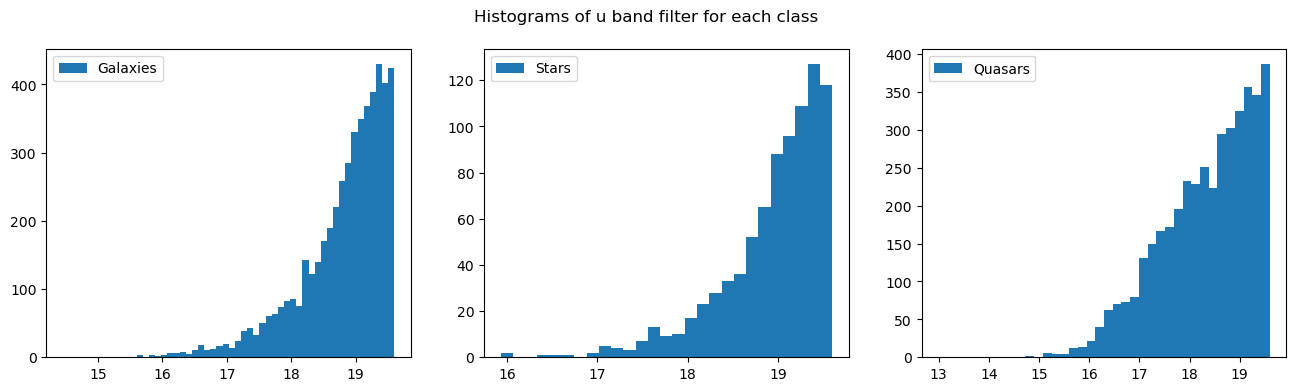

In [14]:
# Plot of histograms
import warnings
warnings.filterwarnings('ignore')
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
for i in range(3):
    q25, q75 = np.percentile(sdss_df[sdss_df['class']==i]['u'], [25, 75])
    bin_width = 2 * (q75 - q25) * len(sdss_df[sdss_df['class']==i]['u']) ** (-1/3)
    bins = round((sdss_df[sdss_df['class']==i]['u'].max() - sdss_df[sdss_df['class']==i]['u'].min()) / bin_width)
    if i == 0:
        axes[i].hist(sdss_df[sdss_df['class']==i]['u'],bins=bins,label='Galaxies');
        axes[i].legend()
    if i == 1:
        axes[i].hist(sdss_df[sdss_df['class']==i]['u'],bins=bins,label='Stars');
        axes[i].legend()
    if i == 2:
        axes[i].hist(sdss_df[sdss_df['class']==i]['u'],bins=bins,label='Quasars');
        axes[i].legend()
plt.suptitle('Histograms of u band filter for each class');

(12.5, 20.0)

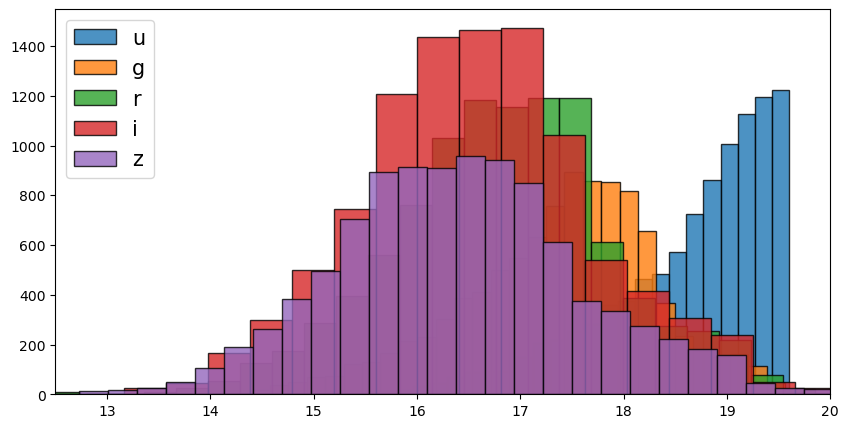

In [15]:
plt.figure(figsize = (10, 5))
for c in ['u', 'g', 'r', 'i', 'z']:
    plt.hist(sdss_df[c], 40, edgecolor = 'k', alpha = 0.8, label = c)
plt.legend(fontsize = 15)
plt.xlim([12.5, 20])

<!-- Anwer: -->
The U band is obviously the only distribution that isn't similar to the other bands

### 1.6 Data Dimensionality Reduction
At this point, we are left with 8 features: redshift, u, g, r, i, z, ra, and dec. Among these, the filters (u, g, r, i, z) are correlated to each other. There is therefore a potential for reducing the dimensions of the features using PCA on these 5 features.

We will use the skilearn function ``sklearn.decomposition.PCA()`` to fit and transform the data into the PC coordinates. Lets' first explore how many PCs we need. Fit the PCA function over the total number of filters. You will fit the PCA function over an array with the columns selected from the dataframe. 

**Task: Perform the PCA over a max number of PCs, output the explained variance ratio values, decide on an appropriate maximum number of PC to use (6 points)**

In [16]:
# anwer
import sklearn.decomposition
from sklearn.decomposition import PCA
pca = sklearn.decomposition.PCA()
X = np.vstack([sdss_df['u'],sdss_df['g'],sdss_df['r'],sdss_df['i'],sdss_df['z']])
# pca.fit(X)
# print(f'PCA components \n{pca.components_}')
# print(f'PCA variance {pca.explained_variance_}')
# print(f'PCA singular values {pca.singular_values_}')

In [17]:
pca=PCA(n_components=5).fit(X.transpose())# retain all 3 components
print(f'PCA components \n{pca.components_}')
print(f'PCA variance {pca.explained_variance_}')
print(f'PCA singular values {pca.singular_values_}')

PCA components 
[[ 0.26869654  0.41062649  0.47829212  0.50442479  0.5253383 ]
 [-0.82288772 -0.32411621  0.04437208  0.25712818  0.38693759]
 [-0.46961419  0.56874104  0.45948949 -0.16131074 -0.46780807]
 [ 0.01247918 -0.08376217 -0.17053457  0.80637244 -0.55991929]
 [ 0.1731033  -0.62916778  0.72736176 -0.05641862 -0.20480469]]
PCA variance [4.93938302 0.47898392 0.02506316 0.02242287 0.00620751]
PCA singular values [222.23611499  69.20520393  15.83055841  14.97351892   7.87837837]


[0.90265505 0.08753264 0.00458021 0.0040977  0.0011344 ]


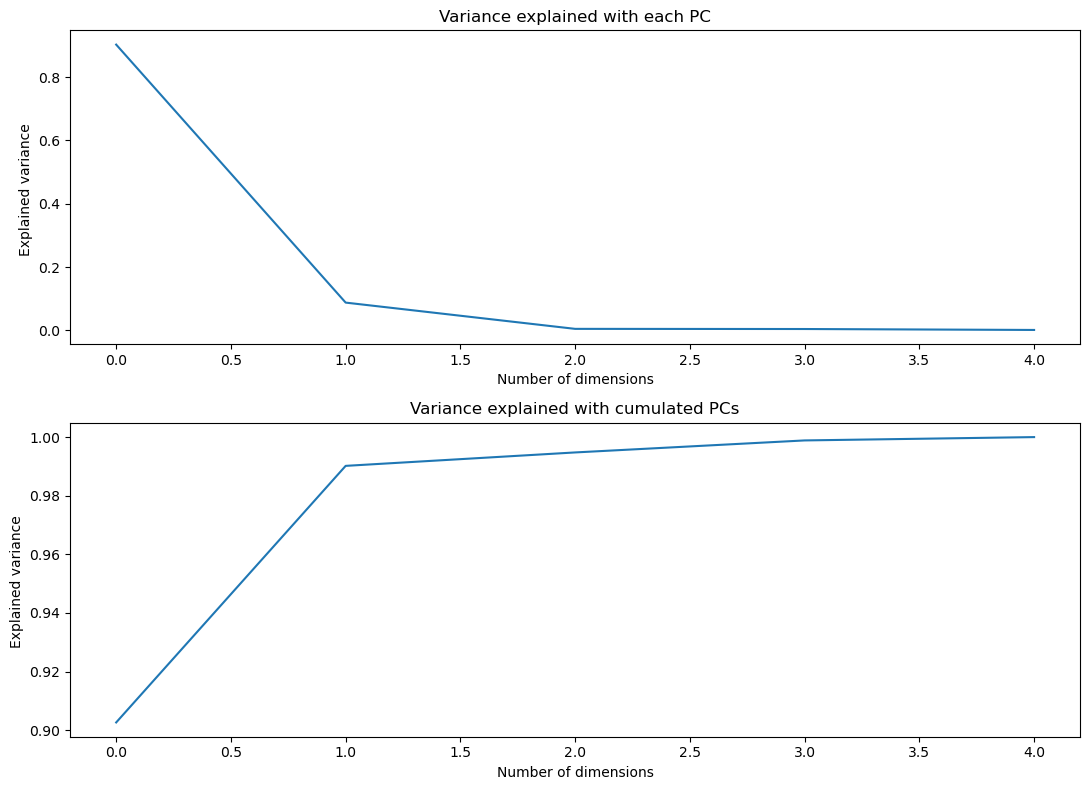

In [18]:
print(pca.explained_variance_ratio_)
fig,ax=plt.subplots(2,1,figsize=(11,8))
ax[0].plot(pca.explained_variance_ratio_)
ax[0].set_xlabel('Number of dimensions')
ax[0].set_ylabel('Explained variance ')
ax[0].set_title('Variance explained with each PC')
ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('Number of dimensions')
ax[1].set_ylabel('Explained variance ')
ax[1].set_title('Variance explained with cumulated PCs')
fig.tight_layout()

*Answer on how many PCs to use*
The majority of the variance is explained by the 1st principle component. In fact over 90% but we we can use the first 2 PCs to get over 95% so we'll use them moving forward

We will now re-perform PCA with the number of PCs you found is most appropriate. Re-apply the fit-transform function. Update the dataframe by adding the PCA value(s) and dropping the columns of the 5 filter features.

**Task: PCA again, fit and transform, update the dataframe with the new feature(s) (3 points)**

In [19]:
# answer
d = np.argmax(np.cumsum(pca.explained_variance_ratio_)>=0.95) + 1
print(f'Number of PCs that explain >= 95% of the variance: {d}')

Number of PCs that explain >= 95% of the variance: 2


In [20]:
# answer
pca = PCA(n_components=d).fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (5, 10000)
transformed shape: (5, 2)


(5, 10000)


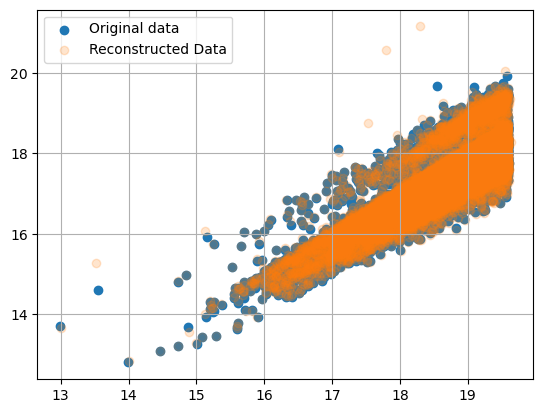

In [21]:
X_new = pca.inverse_transform(X_pca)
print(X_new.shape)
plt.scatter(X[0,:], X[1,:], alpha=1)
plt.scatter(X_new[0,:], X_new[1,:], alpha=0.2)
plt.legend(['Original data','Reconstructed Data'])
plt.grid(True)
plt.show()

## 2) Machine Learning Models (26 points)

We will now train different models on this dataset. We have a total of 8 features, 3 classes, and 10,000 samples. We will use K-Nearest Neighbors, Naive Bayes, Random Forest, Support Vector Machine, Multi Layer Perceptron.

We now follow a normal machine learning workflow:
* Feature scaling (2 points)
* Train/test set split (2 points)
* Model design, training, testing (15 points)
* Model comparisons, pick your winner, discuss feature importance using Random Forest. (10 points)

### 2.1 Feature Scaling
Scaling all values to be within the (0, 1) interval will reduce the distortion due to exceptionally high values and make some algorithms converge faster. You can scale the features only by dropping the "class" column without modifying the dataframe in place, using the pandas function ``drop()``.

**Task: Scale just the features (2 points)**

In [53]:
X = np.array(sdss_df[['u', 'g', 'r', 'i', 'z', 'ra', 'dec', 'redshift']])
Y = np.array(sdss_df['class'])
X -= np.min(X, axis = 0)
X /= np.max(X, axis = 0)
# answer
# print(np.min(sdss_df.drop('class',axis=1)),np.max(sdss_df.drop('class',axis=1)))
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit_transform(sdss_df.drop('class',axis=1))# fit the model for data normalization
# newdata = scaler.transform(sdss_df.drop('class',axis=1)) # transform the data. watch that data was converted to a numpy array
# plt.hist(newdata);
# plt.xlabel('Values')
# plt.ylabel('Counts')

### 2.2 Test, train, validation data sets.
**Task: Split the data into a training and a test part.  (2 points)**

The models will be trained on the training data set and tested on the test data set

In [56]:
idx_train = np.random.choice(np.arange(10000), 8000, replace = False)
idx_test = np.setdiff1d(np.arange(10000), idx_train)

X_train = X[idx_train, :]
y_train = Y[idx_train]

X_test = X[idx_test, :]
y_test = Y[idx_test]
# answer
# import sklearn
# from sklearn.model_selection import train_test_split
# print(f"There are {sdss_df.drop('class',axis=1).shape[1]} features and {sdss_df.drop('class',axis=1).shape[0]} data samples")
# X_train, X_test, y_train, y_test = train_test_split(sdss_df.drop('class',axis=1),sdss_df['class'], test_size=0.8, shuffle=False)

Computation time is important to account for when scaling up the data set and the model size. You can evaluate the relative computational time using the function ``time.perf_counter()`` to evaluate the absolute time. Then compare the computational time by making the difference between two time stamps:

``t1=time.perf_counter()``

``t2=time.perf_counter()``

``tcomp = t2 - t1``

We will also assess the model performance of these multi-class classifiers. We will evaluate the average of the scores over the 3 class labels.

In [57]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_predict
label_name = ['Star','Galaxy','Quasar']

In the following, we will be testing over several classifiers. Follow the steps:
1. model definition/design
2. training
3. prediction on test
4. evaluation: a) print the classification_report; b) save the precision, recall, fscore and accuracy in variables

### 2.3.a K Nearest Neighbors (3 points)
Check out the function arguments and definition here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [84]:
#answer
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
print("Classifying using K-nearest Neighbors")
t1 = time.perf_counter()
# model design
knn_clf = KNeighborsClassifier() 
# training
knn_clf.fit(X_train, y_train) 
# evaluation on test
knn_pred = knn_clf.predict(X_test) 
t2=time.perf_counter()
print(t2 - t1)
# print the classification report
print("K-nearest Neighbors Accuracy:", metrics.accuracy_score(y_true=y_test ,y_pred=knn_pred))
# save values of precision, recall, fscore, accuracy.
print(classification_report(y_test, knn_pred))
knn_report=classification_report(y_test, knn_pred,output_dict=True)

Classifying using K-nearest Neighbors
0.0852385638281703
K-nearest Neighbors Accuracy: 0.8745
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       990
           1       0.99      0.89      0.94       182
           2       0.84      0.88      0.86       828

    accuracy                           0.87      2000
   macro avg       0.91      0.88      0.89      2000
weighted avg       0.88      0.87      0.87      2000



### 2.3.b Naive Bayes (3 points)
Check out the sklearn tutorial pages here: https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes. We propose to use the Gaussian Naive Bayes.

Naive Bayes assumes the data to be normally distributed which can be achieved by scaling using the MaxAbsScaler. For this example then we will use the unscaled data, then rescale it.

In [85]:
# answer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MaxAbsScaler
print("Classifying using Gaussian Naive Bayes")
t1 = time.perf_counter()
# model design
scaler_gnb=MinMaxScaler()
gnb = GaussianNB()

# re-scale the data
sdss = scaler_gnb.fit_transform(sdss_df.drop('class', axis=1))
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, sdss_df['class'], test_size=0.33)

# training
gnb.fit(X_train_gnb, y_train_gnb)

# evaluation
y_pred_gnb = gnb.predict(X_test_gnb)
t2=time.perf_counter()
print(t2 - t1)
# evaluation: 
# print the classification report
print("GNB Accuracy:", metrics.accuracy_score(y_true=y_test_gnb ,y_pred=y_pred_gnb))
# save values of precision, recall, fscore, accuracy.
print(classification_report(y_test_gnb, y_pred_gnb))
gnb_report=classification_report(y_test_gnb, y_pred_gnb,output_dict=True)

Classifying using Gaussian Naive Bayes
0.011188484728336334
GNB Accuracy: 0.9745454545454545
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1650
           1       0.83      0.95      0.89       288
           2       0.99      0.98      0.99      1362

    accuracy                           0.97      3300
   macro avg       0.94      0.97      0.95      3300
weighted avg       0.98      0.97      0.98      3300



### 2.3.c Random Forest Classifier (2 points)
Check out the tutorial page here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [86]:
# answer
from sklearn.ensemble import RandomForestClassifier
print("Classifying using Random Forest Classifiers")

t1=time.perf_counter()
# model design
rf_clf = RandomForestClassifier(random_state=42, verbose=True) 

# training
rf_clf.fit(X_train, y_train)

# evaluation
rf_prediction = rf_clf.predict(X_test) # predict on test
t2=time.perf_counter()
print(t2 - t1)
# evaluation: 
# print the classification report
print("Random Forest Accuracy:", metrics.accuracy_score(y_true=y_test ,y_pred=rf_prediction))
# save values of precision, recall, fscore, accuracy.
print(classification_report(y_test, rf_prediction))
rf_report=classification_report(y_test, rf_prediction,output_dict=True)

Classifying using Random Forest Classifiers


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.4166267039254308
Random Forest Accuracy: 0.9855
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       990
           1       0.98      0.91      0.94       182
           2       0.99      1.00      0.99       828

    accuracy                           0.99      2000
   macro avg       0.98      0.96      0.97      2000
weighted avg       0.99      0.99      0.99      2000



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### 2.3.d Support Vector Machine Classifier (2 points)
Check out the sklearn information page here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

In [87]:
# answer
from sklearn.svm import SVC
print("Classifying using Support Vector Machine Classfiers")

# model design
svc_clf = SVC() 

# training
svc_clf.fit(X_train, y_train) # learn

# evaluation
svc_prediction = svc_clf.predict(X_test) # predict on test

# evaluation: 
# print the classification report
print("SVC Accuracy:", metrics.accuracy_score(y_true=y_test ,y_pred=svc_prediction))
# save values of precision, recall, fscore, accuracy.
print(classification_report(y_test, svc_prediction))
svc_report=classification_report(y_test, svc_prediction,output_dict=True)

Classifying using Support Vector Machine Classfiers
SVC Accuracy: 0.9205
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       990
           1       0.99      0.90      0.94       182
           2       0.87      0.98      0.92       828

    accuracy                           0.92      2000
   macro avg       0.94      0.92      0.93      2000
weighted avg       0.93      0.92      0.92      2000



### 2.3.e Multi-Layer Perceptron (3 points)

Check out the information page here: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [88]:
# answer
from sklearn.neural_network import MLPClassifier
print("Classifying using Multi Layer Perceptron Classifier")


# model design
mlp_clf = MLPClassifier(random_state=1, max_iter=300)
# training
mlp_clf.fit(X_train, y_train)
# evaluation
y_pred_mlp = mlp_clf.predict(X_test)
# evaluation: 
# print the classification report
print("MLP Accuracy:", metrics.accuracy_score(y_true=y_test ,y_pred=y_pred_mlp))
# save values of precision, recall, fscore, accuracy.
print(classification_report(y_test, y_pred_mlp))
mlp_report=classification_report(y_test, y_pred_mlp,output_dict=True)

Classifying using Multi Layer Perceptron Classifier
MLP Accuracy: 0.9795
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       990
           1       0.97      0.92      0.94       182
           2       0.98      1.00      0.99       828

    accuracy                           0.98      2000
   macro avg       0.98      0.97      0.97      2000
weighted avg       0.98      0.98      0.98      2000



### 2.4 Model performance and comparison 

### 2.4.a Confusion Matrix and interpretation

**Task: Plot the confusion matrix (2 points)**

Use the sklearn function ``plot_confusion_matrix``. Find help here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html. We tested 5 models, make suplots, set the title on each subplots.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


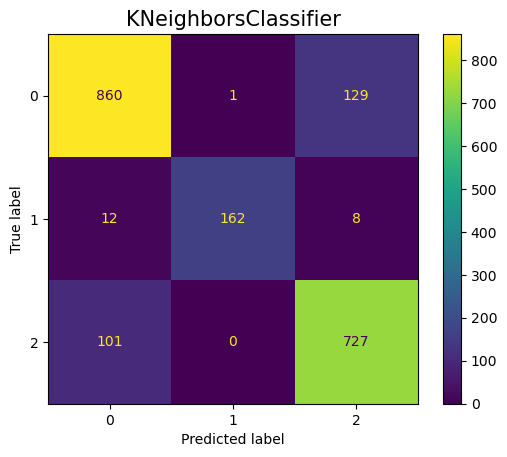

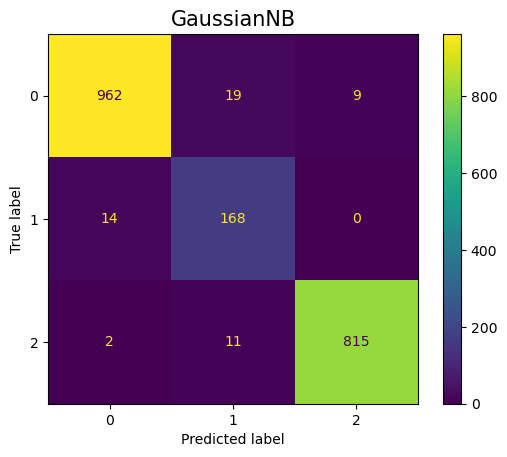

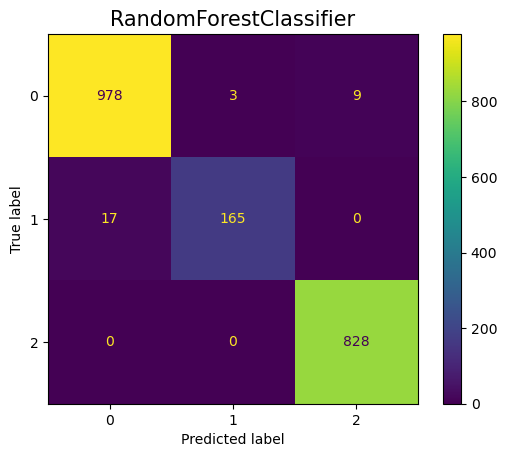

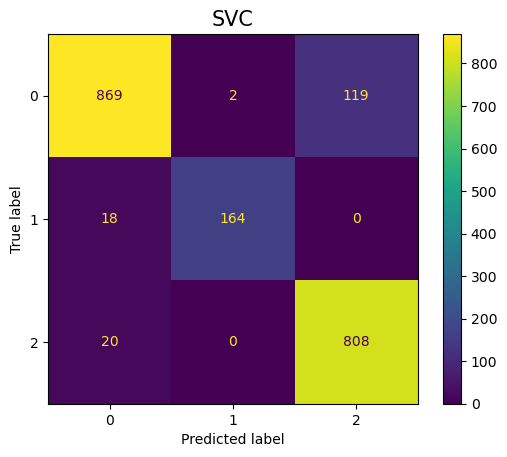

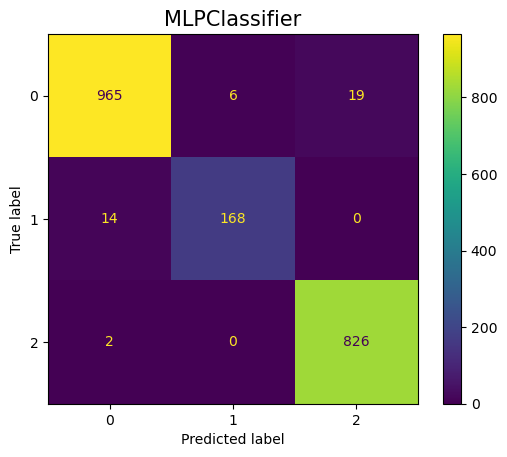

In [89]:
# plot the confusion matrix
for model in [knn_clf, gnb, rf_clf, svc_clf, mlp_clf]:
    if model == gnb:
        X_test = sdss[idx_test, :]
        y_test = Y[idx_test]
    else:
        X_test = X[idx_test, :]
        y_test = Y[idx_test]
    plot_confusion_matrix(model, X_test, y_test)
    plt.title(str(model.__class__).split(".")[-1].split("'")[0], fontsize = 15)

**Task: Comment on what you see the best classifier is likely to be (1 point).** You can also comment on the misclassification and confusion rates.

The best 2 classifiers are the Random Forest and the MLP according to the confusion matrices. These matrices have the smallest values on the off diagonal elements indicating the best performance.

### 2.4.a K Fold Cross Validation
We will now perform k fold cross valdiation for the classifiers. We use the function ``cross_val_score`` on each ewstimator, on the training set, with 10 folds, and use accuracy as a score metric.

**Task: perform the cross validation over K folds, output the mean and standard deviation of the accuracy (3 points)**

In [90]:
from sklearn.model_selection import cross_val_score
# print("K-nearest neighbors Mean:", scores_knn.mean(),"Standard Deviation:", scores_knn.std())
for model in [knn_clf, gnb, rf_clf, svc_clf, mlp_clf]:
    print(f"Working on {model}")
    if model == gnb:
        X_data = sdss
    else:
        X_data = X
    scores = cross_val_score(model, X_data, Y, cv = 10)
    
    print("Model Mean: %.3f Standard Deviation:  %.3f" % (scores.mean(), scores.std()))

Working on KNeighborsClassifier()
Model Mean: 0.866 Standard Deviation:  0.018
Working on GaussianNB()
Model Mean: 0.978 Standard Deviation:  0.008
Working on RandomForestClassifier(random_state=42, verbose=True)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Model Mean: 0.990 Standard Deviation:  0.003
Working on SVC()
Model Mean: 0.931 Standard Deviation:  0.006
Working on MLPClassifier(max_iter=300, random_state=1)
Model Mean: 0.984 Standard Deviation:  0.006


**Task: Which method won the Xval test (1 point) ?**

The Random Forest Classifier

<!-- answer here -->





### 2.4.c And the winner is ...

Let's compare the results. 
**Task: Create a pandas dataframe with all of the performance metrics, including the results from K-fold cross validation. (2 points)**

In [110]:
# create data frame
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 'Random Forest', 'SVC','MLP'],
    'Accuracy': [knn_report['accuracy'],gnb_report['accuracy'],rf_report['accuracy'],svc_report['accuracy'],mlp_report['accuracy']],
    'Precision': [knn_report['0']['precision'],gnb_report['0']['precision'] ,rf_report['0']['precision'] ,svc_report['0']['precision'] ,mlp_report['0']['precision']],
    'Recall': [knn_report['0']['recall'],gnb_report['0']['recall'] ,rf_report['0']['recall'],svc_report['0']['recall'] ,mlp_report['0']['recall']],
    'Fscore': [knn_report['0']['f1-score'],gnb_report['0']['f1-score'] ,rf_report['0']['f1-score'],svc_report['0']['f1-score'] ,mlp_report['0']['f1-score']],
    'Kfold_accuracy_mean': [0.866,0.978,0.990,0.931,0.984]})
# sort values by the Fscore with the greatest value first.

**Task: Comment on the accuracy and performance and choose a winner. (1 point)**



In [111]:
results

,Model,Accuracy,Precision,Recall,Fscore,Kfold_accuracy_mean
0,KNN,0.874500,0.883864,0.868687,0.876210,0.866
1,Naive Bayes,0.974545,0.988315,0.973939,0.981074,0.978
2,Random Forest,0.985500,0.982915,0.987879,0.985390,0.990
3,SVC,0.920500,0.958104,0.877778,0.916183,0.931
4,MLP,0.979500,0.983690,0.974747,0.979198,0.984


<!-- answer here -->






## 3 Summary (4 points)

### 3.1 Feature Importance using Random Forest Classifier

Decision Trees have the unique property of being able to order features by their ability to split between the classes. If some features dominate over other in the predictive power of classes, one can further reduce the dimension of the features for additional analysis. The vector of feature importance is the module ``rfc.feature_importances_``, sorted with ascending importance. Store the vector of importance .

**Task: plot a bar plot using the function ``matplotlib.pyplot.bar``. (2 points)**

Text(0, 0.5, 'Importance')

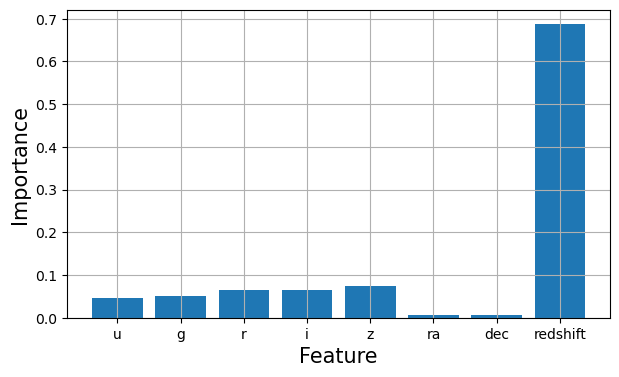

In [115]:
# answer
# vector of importance
# vector of features

plt.figure(figsize = (7, 4))
plt.bar(np.arange(8), rf_clf.feature_importances_)
plt.xticks(np.arange(8), ['u', 'g', 'r', 'i', 'z', 'ra', 'dec', 'redshift']);
plt.grid(True)
plt.xlabel("Feature", fontsize = 15)
plt.ylabel("Importance", fontsize = 15)

**Task: What are the top three features (1 point)?**

redshift, and bands i and z

<!-- answer -->

In this notebook, you have learned that redshift was the best predictor of what object you are observing. Now, did you actualy need to do this all to find this out? Probably not if you were an astrophysicist! But hey, we are not. So great job!

**Task: Briefly comment on what you have learned (1 point)**

I certainly have a much better idea of how to use various kinds of classifiers for training, fitting and predicting data.

## Bonus questions (5 points)


Perform hyperparameter tuning and ensemble learning to improve on the classification performance.

<!-- answer -->